In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from tqdm.notebook import trange, tqdm
from numba import jit
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.cluster import SpectralClustering

In [1]:
import networkx as nx

In [68]:
tqdm.pandas()

C:\Users\Roozbeh\Anaconda3\envs\similarity_matching\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
# os.chdir(r"/raid6/roozbeh/trip_similarity/"

In [3]:
data_path_base = r"../data/"

In [ ]:
# ODdf = pd.read_parquet(os.path.join(data_path_base,'morning_ODdf.parquet'))
# ODdf.columns = ['orig time','orig x','orig y','orig spd','dest time','dest x','dest y','dest spd']

In [6]:
morningdf_no_nan = pd.read_parquet(os.path.join(data_path_base, r"koln_morning_dataframe.parquet"))

In [9]:
xmax = morningdf_no_nan.x.max()
xmin = morningdf_no_nan.x.min()
ymax = morningdf_no_nan.y.max()
ymin = morningdf_no_nan.y.min()
tmax = morningdf_no_nan.time.max()
tmin = morningdf_no_nan.time.min()

In [16]:
morningODdf = pd.read_parquet('ODdf_forcarpoolv2')

In [916]:
ODdf = morningODdf[morningODdf['displacement(km)']<=3]

In [917]:

ODdf

,orig time,orig x,orig y,dest time,dest x,dest y,timediff(h),displacement(km)
trip_id,,,,,,,,
1000024,0.263453,0.420249,0.567624,0.280675,0.368769,0.561977,0.069167,1.035769
1000057,0.748997,0.356375,0.383800,0.769470,0.280688,0.424197,0.082222,1.715862
1000063,0.329229,0.352618,0.364284,0.359732,0.310505,0.425931,0.122500,1.493158
1000074,0.466455,0.070212,0.539355,0.497303,0.130520,0.442940,0.123889,2.274464
1000075,0.547240,0.134015,0.449135,0.571656,0.070481,0.539422,0.098056,2.208023
...,...,...,...,...,...,...,...,...
727160,0.573039,0.268764,0.443596,0.599599,0.406969,0.441212,0.106667,2.764520
727729,0.650228,0.340033,0.535905,0.677203,0.348349,0.425459,0.108333,2.215168
73013,0.576221,0.804917,0.152156,0.585143,0.841304,0.147509,0.035833,0.733637


#### Parameters

In [918]:
spatial_threshold = 0.05*4 #area is roughly 20x20km so let's say distance 1 = 20km => 0.05 = 1km

time_threshold = 1800/(tmax - tmin) #600 seconds

w_t = 0.34
w_x = 1 - w_t

In [919]:
mpl.rc('text', usetex=True)
mpl.rcParams['font.monospace'] = ['Computer Modern Typewriter','DejaVu Sans Mono','Bitstream Vera Sans Mono','Courier']
sns.set(style = 'darkgrid', context = 'paper', font_scale=4)
sns.set_palette("bright")
mpl.rcParams['font.family'] = ['monospace']

##### We get a sample of trips to schedule

In [920]:
reqDF = ODdf[ (ODdf['orig time'] >= 0.30) & (ODdf['dest time'] <= 0.70) ].sample(n=2000, random_state=12345)

# ridesDF = ODdf[~ ODdf.index.isin(ridersDF.index)]

In [921]:
reqDF

,orig time,orig x,orig y,dest time,dest x,dest y,timediff(h),displacement(km)
trip_id,,,,,,,,
385900,0.395560,0.455275,0.410986,0.420943,0.395868,0.397153,0.101944,1.219940
1115530,0.346106,0.374238,0.556402,0.368654,0.421749,0.562872,0.090556,0.958983
1416564,0.599461,0.445365,0.522782,0.613985,0.501049,0.524044,0.058333,1.113963
114514,0.379651,0.603492,0.310894,0.528635,0.600986,0.169768,0.598333,2.822973
1191561,0.484714,0.564873,0.603116,0.494536,0.521957,0.650210,0.039444,1.274305
...,...,...,...,...,...,...,...,...
1339535,0.332411,0.400968,0.336187,0.342786,0.418654,0.361539,0.041667,0.618235
1194314,0.405381,0.492322,0.528160,0.426823,0.579904,0.462936,0.086111,2.184020
244835,0.328607,0.340966,0.500812,0.352746,0.336025,0.609513,0.096944,2.176276


In [861]:
# reqDF.reset_index(inplace=True)

#### We want to service all nodes of REQDF with minimum number of cars.

Hence minimum path partitioning of a graph is neeed. The graph is a DAG based on drop off times being less than pick up times. Hence, it has a polynomial time algorithm that works by constructing a bi partitie graph with n nodes on each part where an edge only exists between nodes from left to right if in the DAG a->b then here a in left part and b in right part would have an edge (not directed though). We use this bipartite graph to do maximum weight matching which correponds to the path partitioning in the original DAG.

In [1030]:
del G
G = nx.Graph()

In [1031]:
# G.add_nodes_from([i for i in range(2*len(reqDF))])
G.add_nodes_from(reqDF.index, bipartite=0)
G.add_nodes_from([i+'_x' for i in reqDF.index], bipartite=1) #everything is added twice to make it bipartate!

In [1032]:
import numba 
from numba import jit
import numpy as np

#weighted geometric mean between time and space. arithmetic mean between origin and dest (/2).
@numba.jit(nopython=False)
def get_trip_similarity_wgm(t1, t2, w_x = 0.5, w_t = 0.5):
#     if w_x + w_t != 1:
#         raise Exception("sum of w_x and w_t must be 1")
    odist = np.sqrt( (t1[1] - t2[1]) ** 2 + (t1[2] - t2[2])**2 )
    ddist = np.sqrt( (t1[4] - t2[4]) ** 2 + (t1[5] - t2[5])**2 )
    ot = np.absolute(t1[0]-t2[0])
    dt = np.absolute(t1[3]-t2[3])
    sim = np.exp(w_x * np.log(1./(1+odist)) + w_t * np.log(1./(1+ot)) )
    sim += np.exp(w_x * np.log(1./(1+ddist)) + w_t * np.log(1./(1+dt)) )
    return(sim/2)

In [1033]:
count_no_potential = 0
for row_idx, req in tqdm(reqDF.iterrows(),total=len(reqDF)):
    t_diff = reqDF['orig time'] - req['dest time']
    potential = reqDF[(0 <= t_diff) & (t_diff <= time_threshold)]
    d_diff = np.sqrt( (potential['orig x'] - req['dest x']) ** 2 + (potential['orig y'] - req['dest y'])**2 )
    potential = potential[d_diff <=  spatial_threshold]
    if not potential.empty and len(potential) > 1:
        potential["similarity"] = potential.apply(lambda x : get_trip_similarity_wgm(req.values,x.values),axis=1)
#         G.add_node(req.name, bipartite=0)
#         G.add_node(req.name+'_x', bipartite=1)
        
#         G.add_nodes_from(potential.index.values, bipartitle=0)
#         G.add_nodes_from([i+'_x' for i in potential.index], bipartite=1)
        potential = potential.sort_values('similarity')
        potential[:75].apply(lambda row: G.add_edge(req.name, row.name+'_x', weight=int(row.similarity * 10000)) ,axis=1)
        
    else:
        count_no_potential += 1

    

In [1034]:
print(count_no_potential)

62


In [1035]:
len(G.edges), len(G.nodes)

(132764, 4000)

In [1036]:
len([n for n in G.nodes if n.endswith('_x')])

2000

In [1037]:
max_matching = nx.max_weight_matching(G, maxcardinality=True)

In [968]:
# import json

# with open('max_matching_2k.json', 'w') as fp:
#     json.dump(max_matching, fp, indent=4)

In [1136]:
len(max_matching)

1509

In [1137]:
max_matching

{('1422851', '276197_x'),
 ('112768', '1452056_x'),
 ('1469556_x', '1025468'),
 ('1576464', '1307108_x'),
 ('1585551', '270505_x'),
 ('1467667_x', '1102837'),
 ('1378720', '1192403_x'),
 ('1412581_x', '1311041'),
 ('171619', '1509759_x'),
 ('277559_x', '230088'),
 ('1072576', '1191561_x'),
 ('385330_x', '117687'),
 ('1530735', '222786_x'),
 ('111747', '1557208_x'),
 ('1509365_x', '1109790'),
 ('1490292_x', '368812'),
 ('1280590', '451683_x'),
 ('1565770_x', '1295369'),
 ('1561774_x', '1183913'),
 ('1330503', '1216304_x'),
 ('1350165_x', '1409759'),
 ('144749', '1308493_x'),
 ('11506', '173025_x'),
 ('287167', '1591497_x'),
 ('147379_x', '1358971'),
 ('155295', '1244643_x'),
 ('1308478_x', '1360307'),
 ('139925', '1183261_x'),
 ('184698_x', '1491421'),
 ('375125_x', '1472433'),
 ('1022572', '238245_x'),
 ('192784', '1424480_x'),
 ('1291865_x', '1272899'),
 ('12990_x', '1364536'),
 ('260593', '1228259_x'),
 ('1556631', '1580586_x'),
 ('291959', '1272099_x'),
 ('1465876', '1416564_x'),
 (

In [1141]:
matching_formatted = dict()
for u,v in max_matching:
    if u.endswith('_x'):
        if (v,u) in max_matching:
            print('WHAT? Sample tuple exists')
        matching_formatted[v] = u
    else:
        matching_formatted[u] = v
#     else:
#         matching_formatted[v[:-2]] = u #nope not what should happen!
#         matching_formatted[u] = v-N
#     else:
#         matching_formatted[v] = u-N

In [1142]:
len(max_matching),len(matching_formatted)

(1509, 1509)

In [1143]:
matching_formatted #all _x ones are on the right!

{'1422851': '276197_x',
 '112768': '1452056_x',
 '1025468': '1469556_x',
 '1576464': '1307108_x',
 '1585551': '270505_x',
 '1102837': '1467667_x',
 '1378720': '1192403_x',
 '1311041': '1412581_x',
 '171619': '1509759_x',
 '230088': '277559_x',
 '1072576': '1191561_x',
 '117687': '385330_x',
 '1530735': '222786_x',
 '111747': '1557208_x',
 '1109790': '1509365_x',
 '368812': '1490292_x',
 '1280590': '451683_x',
 '1295369': '1565770_x',
 '1183913': '1561774_x',
 '1330503': '1216304_x',
 '1409759': '1350165_x',
 '144749': '1308493_x',
 '11506': '173025_x',
 '287167': '1591497_x',
 '1358971': '147379_x',
 '155295': '1244643_x',
 '1360307': '1308478_x',
 '139925': '1183261_x',
 '1491421': '184698_x',
 '1472433': '375125_x',
 '1022572': '238245_x',
 '192784': '1424480_x',
 '1272899': '1291865_x',
 '1364536': '12990_x',
 '260593': '1228259_x',
 '1556631': '1580586_x',
 '291959': '1272099_x',
 '1465876': '1416564_x',
 '1002932': '1288989_x',
 '282645': '1462445_x',
 '1141161': '1004986_x',
 '14

In [1144]:
set_left = set(matching_formatted.keys())

In [1145]:
set_right = set(matching_formatted.values())

In [1146]:
len(set_left)

1509

In [1147]:
len(set_left - {i[:-2] for i in set_right})

432

In [1148]:
len(set_left | {i[:-2] for i in set_right})

1941

Number above is the number of nodes that are in a chain

In [1149]:
def get_distance(t):
    return np.sqrt( (t['orig x'] - t['dest x'] ) ** 2 + (t['orig y'] - t['dest y'])**2 )

In [1150]:
def get_e2b_distance(t1,t2):
    return 20 * np.sqrt((t2['orig x'] - t1['dest x']) ** 2 + (t2['orig y'] - t1['dest y'])**2 )

In [1151]:
def get_e2b_time(t1,t2):
    return (tmax-tmin)*(t2['orig time'] - t1['dest time'])

In [1152]:
reqDF["distance"] = reqDF.apply(get_distance,axis=1)

In [1153]:
reqDF

,orig time,orig x,orig y,dest time,dest x,dest y,timediff(h),displacement(km),distance
trip_id,,,,,,,,,
385900,0.395560,0.455275,0.410986,0.420943,0.395868,0.397153,0.101944,1.219940,0.060997
1115530,0.346106,0.374238,0.556402,0.368654,0.421749,0.562872,0.090556,0.958983,0.047949
1416564,0.599461,0.445365,0.522782,0.613985,0.501049,0.524044,0.058333,1.113963,0.055698
114514,0.379651,0.603492,0.310894,0.528635,0.600986,0.169768,0.598333,2.822973,0.141149
1191561,0.484714,0.564873,0.603116,0.494536,0.521957,0.650210,0.039444,1.274305,0.063715
...,...,...,...,...,...,...,...,...,...
1339535,0.332411,0.400968,0.336187,0.342786,0.418654,0.361539,0.041667,0.618235,0.030912
1194314,0.405381,0.492322,0.528160,0.426823,0.579904,0.462936,0.086111,2.184020,0.109201
244835,0.328607,0.340966,0.500812,0.352746,0.336025,0.609513,0.096944,2.176276,0.108814


In [1154]:
all_nodes_x = {s for s in G.nodes if s.endswith('_x')}

In [1155]:
len(all_nodes_x)

2000

---
Number of nodes that are start of a chain (of size 1 or longer):

In [1156]:
len(all_nodes_x - set_right)

491

Number of trips that are start of a chain

In [1157]:
len({s[:-2] for s in set_right} & set_left)

1077

Number of trips not participating to matching (isolated trips):

In [1158]:
len( (all_nodes_x - set_right)- {s+'_x' for s in set_left})

59

In [1159]:
len(all_nodes_x - set_right)

491

In [1160]:
trip_chains = []
pickup_travels = []
pickup_times = []
trip_travels = []
for current in all_nodes_x - set_right: #points in the right part which are not anyone's match are the beginning of chains
    current = current[:-2]
    temp_travels = [reqDF.loc[current,"displacement(km)"]]
    
    temp_trip_chains = [current]
    temp_pickup_travels = []
    temp_pickup_times = []
    while current in set_left:
        _next = matching_formatted[current][:-2] #remove _x suffix
        temp_pickup_travels.append(get_e2b_distance(reqDF.loc[current,:],reqDF.loc[_next,:]))
        temp_pickup_times.append(get_e2b_time(reqDF.loc[current,:],reqDF.loc[_next,:]))
        temp_trip_chains.append(_next)
        current = _next
        
        temp_travels.append(reqDF.loc[current,"displacement(km)"])
        
    pickup_travels.append(temp_pickup_travels)
    trip_travels.append(temp_travels)
    pickup_times.append(temp_pickup_times)
    trip_chains.append(temp_trip_chains)

In [1161]:
trip_chains[:5]

[['1288889', '1047186', '1321401', '1027690', '1229444', '1444940'],
 ['1401698', '1306346', '1569530', '241458'],
 ['1550674', '1192058', '1366783', '1533859'],
 ['1198593', '1518400', '1538060'],
 ['1413940', '1477611']]

In [1162]:
trip_travels[:5]

[[0.6887385357753951,
  1.2750965166209103,
  1.5238035201656148,
  2.96177084492657,
  0.015154156109521512,
  1.8446823044833975],
 [1.9344981238359575,
  0.33471168438194837,
  0.8629566977962857,
  1.9671189928100512],
 [2.115008820539596,
  2.3919034821732605,
  1.6341222778046236,
  0.7880072455270836],
 [2.2277645623901785, 2.326935576408759, 2.349511226172639],
 [1.1777855775860113, 2.7935178432144667]]

In [1163]:
pickup_times[:5]

[[1047.9999999999998,
  881.9999999999998,
  145.0000000000003,
  193.00000000000003,
  47.99999999999974],
 [235.0000000000004, 538.0, 1044.0000000000002],
 [223.00000000000006, 688.9999999999997, 638.0000000000007],
 [6.999999999999661, 1122.0],
 [449.9999999999997]]

In [1164]:
pickup_travels[:5]

[[3.214054166345063,
  3.7777196845801795,
  2.397668899432131,
  0.7518063583229728,
  2.7592276569927594],
 [3.9205148767868203, 3.873194361315608, 3.809081559474879],
 [2.7672987740099413, 3.9463385943454288, 2.378097330343861],
 [3.61444997559244, 3.913435566256012],
 [3.1798749152953283]]

In [1187]:
chain_lengths = [len(x) for x in trip_travels]

Text(0, 0.5, 'Count')

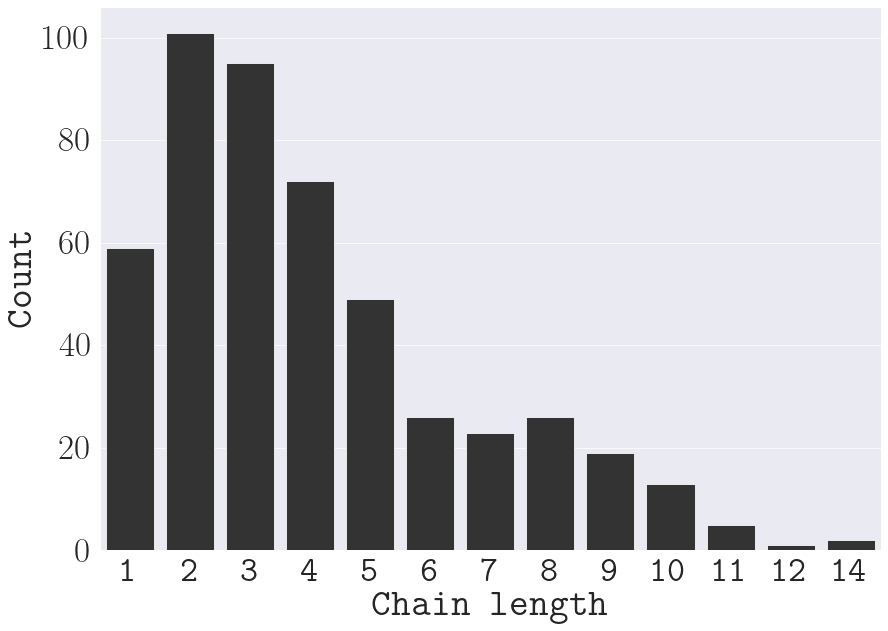

In [1188]:
plt.figure(figsize=(14,10))
sns.countplot(chain_lengths, facecolor=(0.2, 0.2, 0.2, 1))
plt.xlabel('Chain length')
plt.ylabel('Count')

In [1189]:
np.mean(chain_lengths),np.std(chain_lengths)

(4.0733197556008145, 2.5748906957990205)

In [1190]:
np.sum(chain_lengths)

2000

In [1191]:
total_trip_travels = [sum(travel_list) for travel_list in trip_travels]

In [1192]:
total_trip_and_pickup_travels = [sum(travel_list) + sum(pickup_list) for (travel_list,pickup_list) in zip(trip_travels,pickup_travels)]
total_trip_and_pickup_travels_matched_only = [sum(travel_list) + sum(pickup_list) for (travel_list,pickup_list) in zip(trip_travels,pickup_travels) if pickup_list]
total_trip_travels_matched_only = [sum(travel_list) for travel_list in trip_travels if len(travel_list) > 1]

In [1193]:
len(total_trip_and_pickup_travels), len(total_trip_and_pickup_travels_matched_only), len(total_trip_travels_matched_only)

(491, 432, 432)

In [1172]:
total_pickup_times = [sum(time_list) for time_list in pickup_times if time_list]

In [1173]:
total_pickup_times

[2315.9999999999995,
 1817.0000000000007,
 1550.0000000000005,
 1128.9999999999998,
 449.9999999999997,
 523.9999999999999,
 609.9999999999989,
 1112.0000000000002,
 1770.999999999999,
 1459.9999999999995,
 1946.9999999999995,
 1335.9999999999998,
 1602.0000000000014,
 2785.0000000000014,
 687.0000000000007,
 1229.999999999999,
 1656.9999999999993,
 519.9999999999995,
 1483.0,
 2243.999999999999,
 2963.000000000001,
 3185.0000000000005,
 1414.0000000000005,
 2535.9999999999986,
 1148.0000000000014,
 845.0,
 625.9999999999995,
 1196.0,
 1348.9999999999995,
 1815.9999999999982,
 2191.999999999999,
 475.00000000000074,
 954.0000000000001,
 2161.0,
 379.0000000000004,
 1968.9999999999998,
 1513.999999999999,
 1342.9999999999995,
 3306.000000000002,
 1405.9999999999995,
 1683.0000000000005,
 617.0000000000001,
 1433.0000000000011,
 590.9999999999997,
 1351.0000000000002,
 1633.0,
 2042.999999999999,
 2298.0000000000023,
 1162.9999999999993,
 1829.9999999999998,
 1259.0000000000005,
 2828.0,

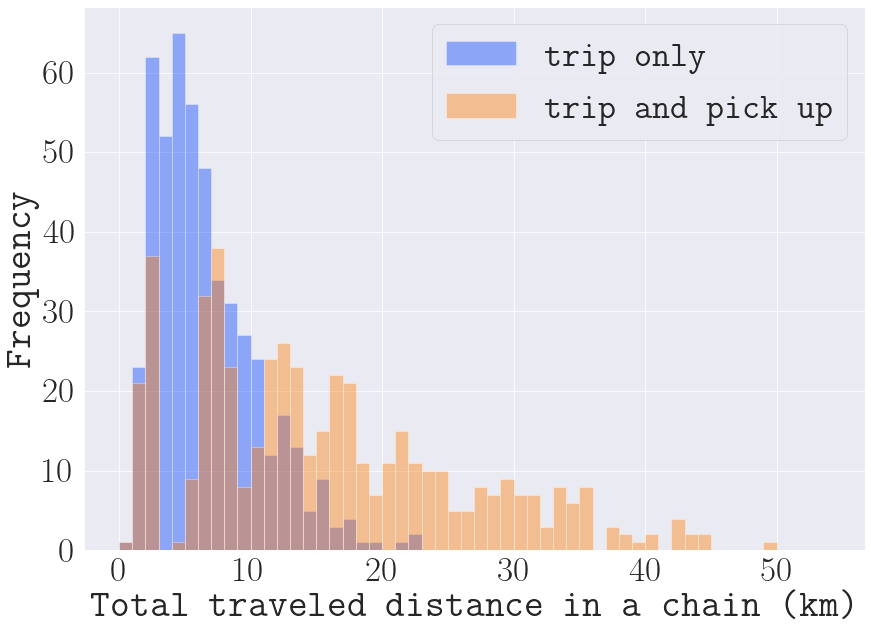

In [1194]:
plt.figure(figsize=(14,10))
sns.distplot(total_trip_travels, bins=[i for i  in range(0,55)], kde=False, label='trip only')
sns.distplot(total_trip_and_pickup_travels, bins=[i for i  in range(0,55)], kde=False, label='trip and pick up')
plt.xlabel('Total traveled distance in a chain (km)')
plt.ylabel('Frequency')
plt.legend()

In [1258]:
np.mean(total_trip_and_pickup_travels), np.mean(total_trip_travels)

(15.66114914132283, 6.686484521943038)

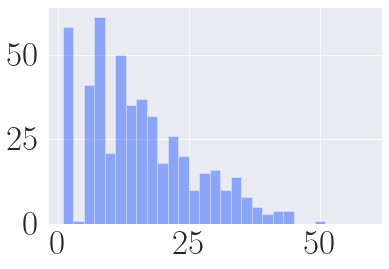

In [1175]:
sns.distplot(total_trip_and_pickup_travels, kde=False, bins = range(1,60,2))

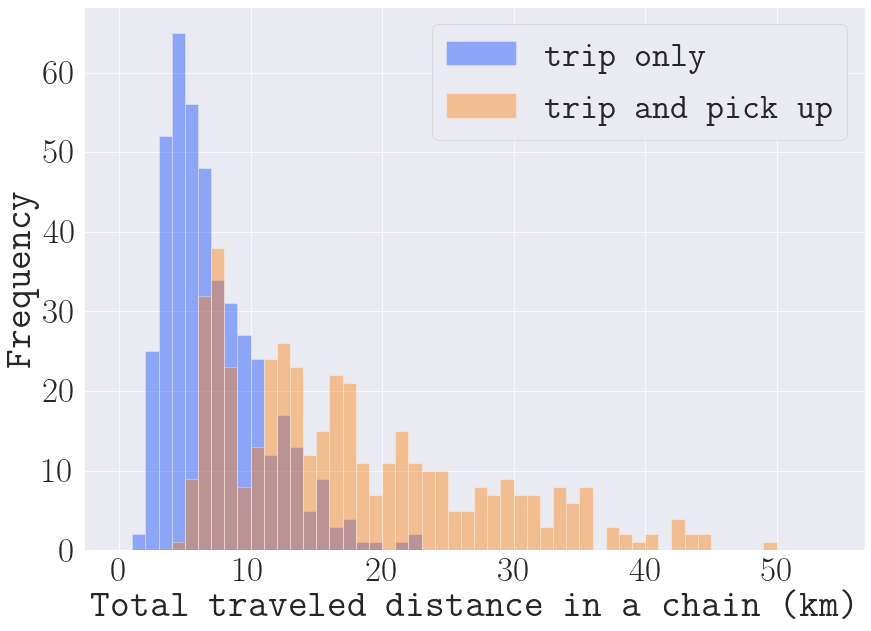

In [1195]:
plt.figure(figsize=(14,10))
sns.distplot(total_trip_travels_matched_only, bins=[i for i  in range(0,55)], kde=False, label='trip only')
sns.distplot(total_trip_and_pickup_travels_matched_only, bins=[i for i  in range(0,55)], kde=False, label='trip and pick up')
plt.xlabel('Total traveled distance in a chain (km)')
plt.ylabel('Frequency')
plt.legend()

Text(2500, 45, 'median=1493.00')

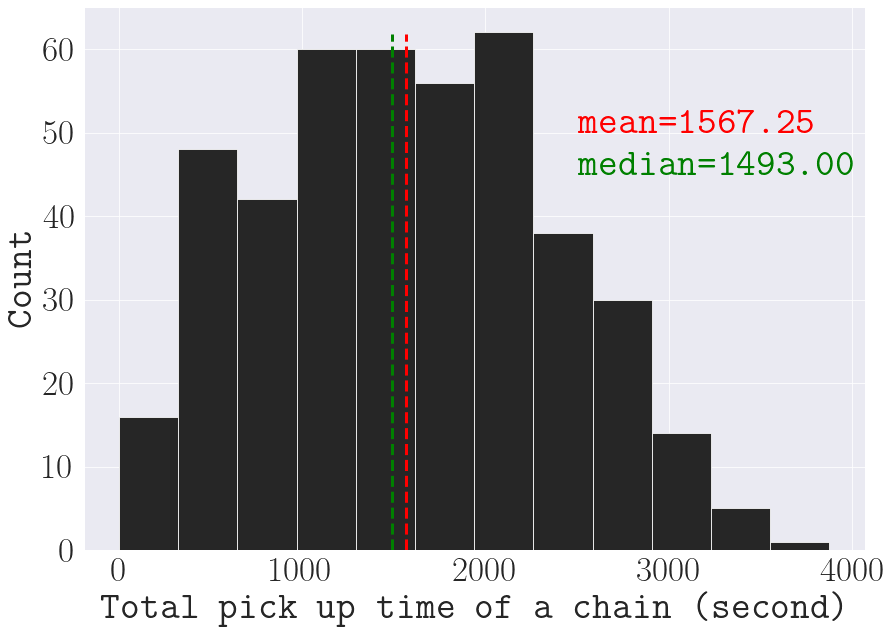

In [1257]:
plt.figure(figsize=(14,10))

sns.distplot(total_pickup_times,kde=False, bins=12, color=(0.15,0.15,0.15,1),hist_kws={'alpha' : 1}) #excluding zeros
plt.xlabel('Total pick up time of a chain (second)')
plt.ylabel('Count')
avg = np.mean(total_pickup_times)
mdn = np.median(total_pickup_times)
plt.axvline(avg, 0, 0.95, color='red', linewidth=3, linestyle='dashed')
plt.axvline(mdn, 0, 0.95, color='green', linewidth=3, linestyle='dashed')
plt.text(2500, 50, 'mean={:.2f}'.format(avg),color='red')# bbox=dict(fill=False, edgecolor='red', linewidth=2))
plt.text(2500, 45, 'median={:.2f}'.format(mdn),color='green')# bbox=dict(fill=False, edgecolor='red', linewidth=2))

In [1178]:
np.mean(total_pickup_times),np.std(total_pickup_times)

(1567.2523148148148, 785.4676501249367)

In [339]:
fig = plt.figure(figsize=(10,6))
ax = sns.distplot(total_trip_travels,kde=False,bins=20,hist_kws={'align':'left',"alpha":0.7,'width':4.})
ax.set_xlabel("total chain travel (km)",fontsize=20)
ax.set_ylabel("frequency",fontsize=20)
# ax.set_xticks(range(11))
# ax.set_xlim(0,10)
ax.tick_params(axis='both', which='major', labelsize=18)

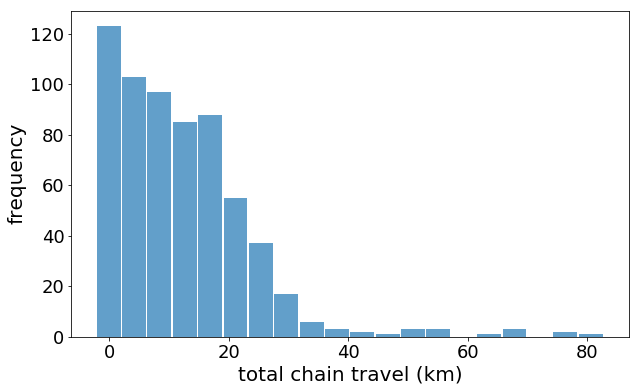

In [340]:
plt.show()

In [304]:
fig = plt.figure(figsize=(10,6))
ax = sns.distplot(total_trip_travels,hist=False, bins=20,kde_kws={'cumulative':True})
ax.set_xlabel("total chain travel (km)",fontsize=20)
ax.set_ylabel("frequency",fontsize=20)
# ax.set_xticks(range(11))
# ax.set_xlim(0,10)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.grid()

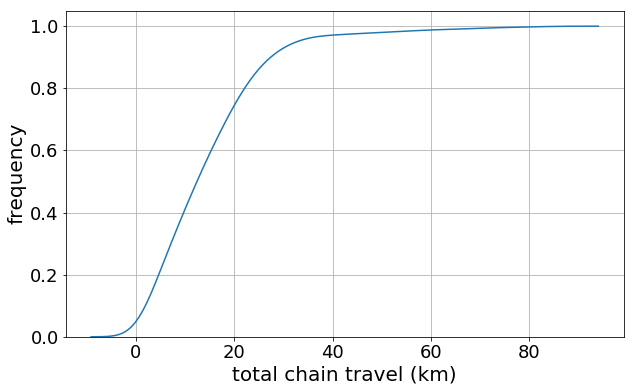

In [305]:
plt.show()

In [278]:
total_pickup_travels = [sum(x)/1000 for x in pickup_travels]

In [331]:
fig = plt.figure(figsize=(10,6))
ax = sns.distplot(total_pickup_travels,kde=False,bins=[i*0.1 for i in range(90)],hist_kws={'align':'left',"alpha":0.7,'width':0.08})
ax.set_xlabel("total travels to pickup (kms)",fontsize=20)
ax.set_ylabel("frequency",fontsize=20)
ax.set_xticks(range(11))
# ax.set_xlim(0,10)
ax.tick_params(axis='both', which='major', labelsize=18)

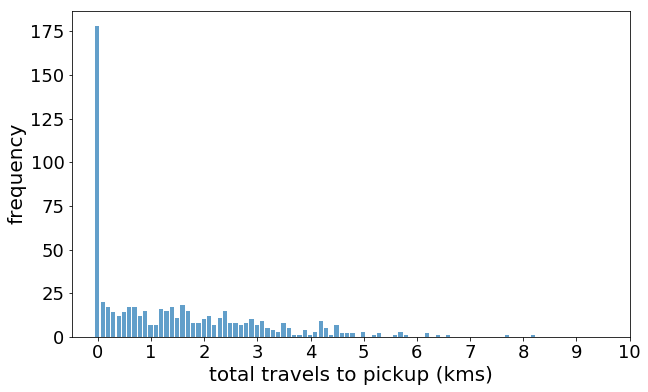

In [332]:
plt.show()

In [349]:
fig = plt.figure(figsize=(10,6))
ax = sns.distplot(total_pickup_travels,hist=False, bins=20,kde_kws={'cumulative':True})
ax.set_xlabel("total travels to pickup (kms)",fontsize=20)
ax.set_ylabel("frequency",fontsize=20)
# ax.set_xticks(range(11))
# ax.set_xlim(0,10)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.grid()

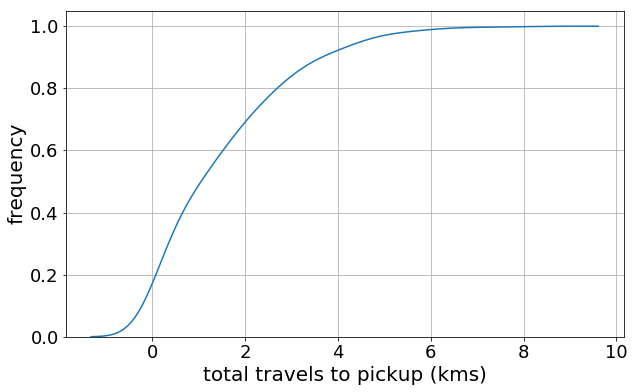

In [350]:
plt.show()

In [351]:
total_pickup_times = [sum(x) for x in pickup_times]

In [352]:
fig = plt.figure(figsize=(10,6))
ax = sns.distplot(total_pickup_times,kde=False,bins=[60*i for i in range(40)],hist_kws={'align':'left',"alpha":0.7,'width':55})
ax.set_xlabel("total time to pickup (s)",fontsize=20)
ax.set_ylabel("frequency",fontsize=20)
# ax.set_xticks(range(11))
# ax.set_xlim(0,10)
ax.tick_params(axis='both', which='major', labelsize=18)

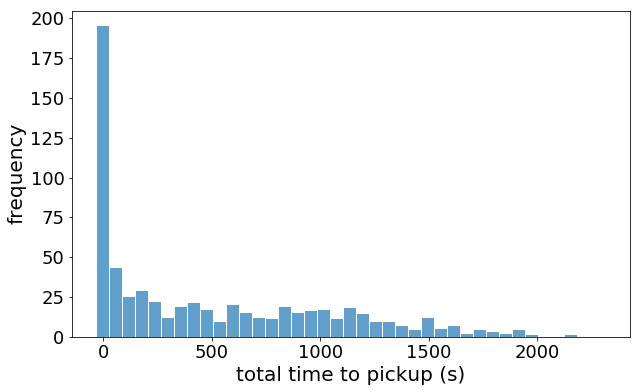

In [353]:
plt.show()

In [354]:
fig = plt.figure(figsize=(10,6))
ax = sns.distplot(total_pickup_times,hist=False, bins=20,kde_kws={'cumulative':True})
ax.set_xlabel("total time to pickup (s)",fontsize=20)
ax.set_ylabel("frequency",fontsize=20)
# ax.set_xticks(range(11))
# ax.set_xlim(0,10)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.grid()

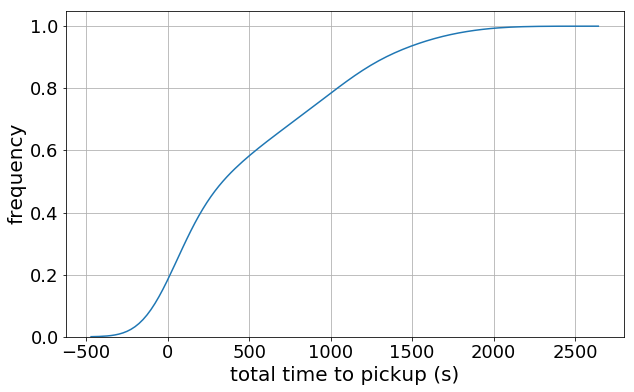

In [355]:
plt.show()